In [4]:
import os
import itertools
import netCDF4
import numpy as np
import numpy.ma as ma
from dask import delayed
import dask.array as da
from dask.distributed import Client
import glob
import tempfile
import subprocess
import datetime

In [5]:
year = 1971
model = 'NorESM1-M'
scenario = 'historical'
download_location = '/temp'
# data_url = 'http://nasanex.s3.amazonaws.com'
data_url = 'http://172.22.0.1:8080'

In [6]:
client = Client('scheduler:8786')
client.restart()

Client Scheduler: tcp://scheduler:8786 Dashboard: http://scheduler:8787,Cluster Workers: 1 Cores: 8 Memory: 33.69 GB


In [7]:
# Actual processing
# We load the temperature baseline from a numpy array in disk
baseline = da.from_array(np.load('/temp/baseline_tasmax_99p.npy'), chunks = (144, 144))

# And define the functions to be applied over each dataset
# This if for a single year, either one of the variables or the
# tasavg stack, which would be calculated on-the-fly

# Heating Degree Days - in C, transformation to F should not be problematic
def hdd(a, axis):
    a_to_baseline = 291.483 - a
    masked = ma.masked_where(a_to_baseline <= 0, a_to_baseline)
    intermediate_matrix = ma.filled(masked, fill_value = 0)
    result = np.sum(intermediate_matrix, axis = 0)
    return result

# Cooling degree days
def cdd(a, axis):
    a_to_baseline = 291.483 - a
    a_to_baseline[a_to_baseline < -10000] = 0
    masked = ma.masked_where(a_to_baseline >= 0, a_to_baseline)
    intermediate_matrix = ma.filled(masked, fill_value = 0)
    result = np.sum(np.abs(intermediate_matrix), axis = 0)
    return result

# Number of days of the year with tasmax > 99 percentile from baseline 1971-2000
def extreme_heat(a, axis):
    a_to_baseline = a - baseline
    masked = ma.masked_where(a_to_baseline <= 0, a_to_baseline)
    intermediate_matrix = ma.filled(masked, fill_value = 0)
    result = np.count_nonzero(intermediate_matrix, axis = axis)
    return result

# Helper function, not to be applied directly on the worker
def longest_streak(diff):
    result = 0
    try:
        result =  np.amax(
            np.array(np.where(diff < 0)) - np.array(np.where(diff > 0))
        )
    except ValueError:
        #raised if empty
        result = 0
    return result

# Longest streak of days over freezing temperature (tasmin)
def frost_free_season(a, axis):
    # First, dealing with the first matrix
    frost_days_matrix = (a > 273.15) * 1
    # We pad it with zeroes at the ends of the designed axis
    zeros_shape = list(a.shape)
    del zeros_shape[axis]
    zeros_matrix = np.expand_dims(np.zeros(zeros_shape), axis = axis)
    concat_matrix = np.concatenate((zeros_matrix, frost_days_matrix, zeros_matrix))
    # We calculate the deltas along an axis
    diff = np.diff(concat_matrix, axis = axis)
    # And get the longest streak from there --
    # apply along axis is far from ideal, but
    # np.where doesn't operate over axes, so we have to iterate
    result = np.apply_along_axis(longest_streak, axis, diff)
    return result

In [8]:
def get_urls(year, model, scenario):
    urls = []
    for var in ['tasmax', 'tasmin']:
        #prefix_filename = '/'.join([data_url, 'NEX-GDDP', 'BCSD', scenario, 'day', 'atmos', var, 'r1i1p1', 'v1.0'])
        prefix_filename = data_url
        filename = '_'.join([var, 'day', 'BCSD', scenario, 'r1i1p1', model, str(year) + '.nc'])
        urls.append('/'.join([prefix_filename, filename]))
    return urls

def download(year, model, scenario):
    tasmax_url, tasmin_url = get_urls(year, model, scenario)
    urls = [tasmax_url, tasmin_url]
    filenames = list(map(lambda url: '/temp/' + url.split('/')[-1],  urls))
    with tempfile.NamedTemporaryFile(mode = 'w', delete = False) as download_list:
        for url in urls:
            download_list.write(url + '\n')
        download_command = f' aria2c -i {download_list.name} --log={download_list.name}.log --log-level=warn --dir /temp --max-tries 5 --retry-wait 5'
        print("Downloading files")
        download_result = subprocess.Popen(download_command, shell=True, stdout=subprocess.PIPE)
    return download_result, filenames
    
def download_and_process(year, model, scenario):
    download_process, filenames = download(year, model, scenario)
    download_result = download_process.wait()
    if download_result != 0:
        raise Exception("There was a problem with the download")
    else:
        filenames_per_var = list(zip(['tasmax', 'tasmin'], filenames))
        print(filenames_per_var)
        vars = list(map(lambda fname: netCDF4.Dataset(fname[1])[fname[0]], filenames_per_var))
        da_arrays = list(map(lambda var: da.from_array(var, chunks = (366, 144, 144)),vars))
        
        base_stack = da.stack(da_arrays)
        tasmax_stack = da_arrays[0]
        tasmin_stack = da_arrays[1]

        tasavg = np.mean(base_stack, axis = 0)
        avg_tasmin = np.mean(tasmin_stack, axis = 0).compute()
        avg_tasmax = np.mean(tasmax_stack, axis = 0).compute()
        avg_tasavg = np.mean(tasavg, axis = 0).compute()
        
        avg_tasmin[avg_tasmin > 1000] = 0
        avg_tasmax[avg_tasmax > 1000] = 0
        avg_tasavg[avg_tasavg > 1000] = 0
        
        hdds = delayed(hdd)(tasavg, axis = 0).compute()
        cdds = delayed(cdd)(tasavg, axis = 0).compute()
        ffs = delayed(frost_free_season)(tasmin_stack, axis = 0).compute()
        xs = delayed(extreme_heat)(tasmax_stack, axis = 0).compute()

        results = np.stack((
            avg_tasmax,
            avg_tasmin,
            avg_tasavg,
            hdds,
            cdds,
            ffs,
            xs
        ))
        np.save(f'/results/{year}_processed_temperatures.npy', results)
        return 0

In [9]:
for ncdf in glob.glob('/temp/*.nc*'):
    os.remove(ncdf)
print(datetime.datetime.now())
res = download_and_process(year, model, scenario)
res
print(datetime.datetime.now())

2017-11-30 12:03:13.574651
[('tasmax', '/temp/tasmax_day_BCSD_historical_r1i1p1_NorESM1-M_1971.nc'), ('tasmin', '/temp/tasmin_day_BCSD_historical_r1i1p1_NorESM1-M_1971.nc')]
2017-11-30 12:08:26.746777


In [10]:
ls -lh /results/

total 56M
-rw-r--r-- 1 jovyan users 56M Nov 30 12:08 1971_processed_temperatures.npy


In [11]:
im = np.load('/results/1971_processed_temperatures.npy')

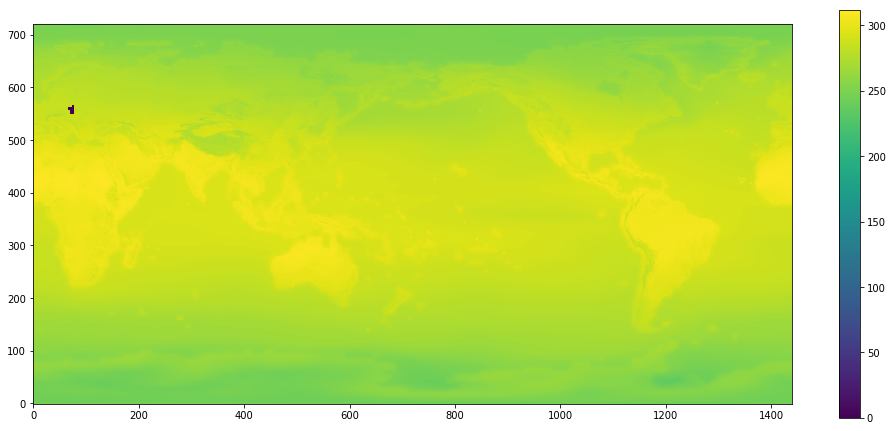

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(17, 7.5))
plt.imshow(im[0, :, :], origin='lower')
plt.colorbar()

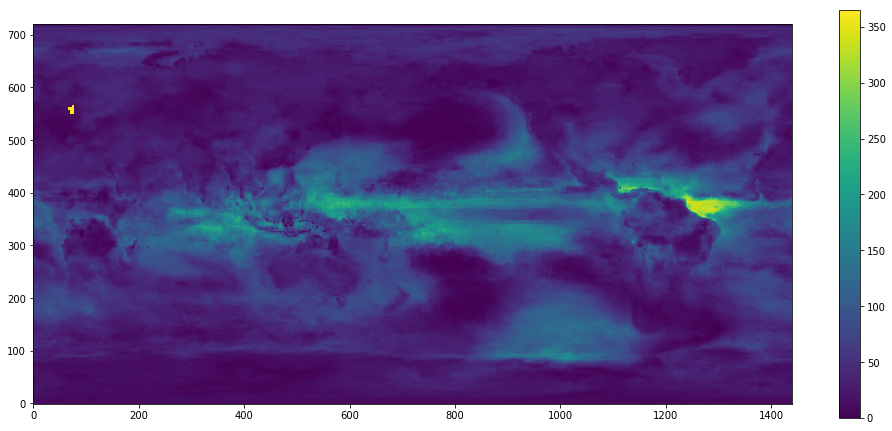

In [19]:
plt.figure(figsize=(17, 7.5))
plt.imshow(im[6, :, :], origin='lower')
plt.colorbar()

In [20]:
ls -lh /results

total 56M
-rw-r--r-- 1 jovyan users 56M Nov 30 12:08 1971_processed_temperatures.npy
